# Photic Zone: Spectrophotometer


This photic zone notebook concerns spectrophotometer data in the upper 200 meters of the water column.
The instrument runs through about 72 spectral channels per observation.


    
### Study site locations
    

Three sites in the northeast Pacific: 
    

```
Site name               Lat               Lon
------------------      ---               ---
Oregon Offshore         44.37415          -124.95648
Oregon Slope Base       44.52897          -125.38966 
Axial Base              45.83049          -129.75326
```   

#### code cells

- intro standard stuff + next cell generates a block of charts
- following cell is 'un-processed' steps towards widget interactivity and so on

#### to do
    
- optaa: rolling mean (days), use min for OA, smooth outliers for BA, animation, thin layer discrimination
- nitrate sample in relation to dark: Does an SME say there is more to do? 

In [4]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D')) # 1, 2, .... , 365, [366]
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


on day 31 i.e. doy 31


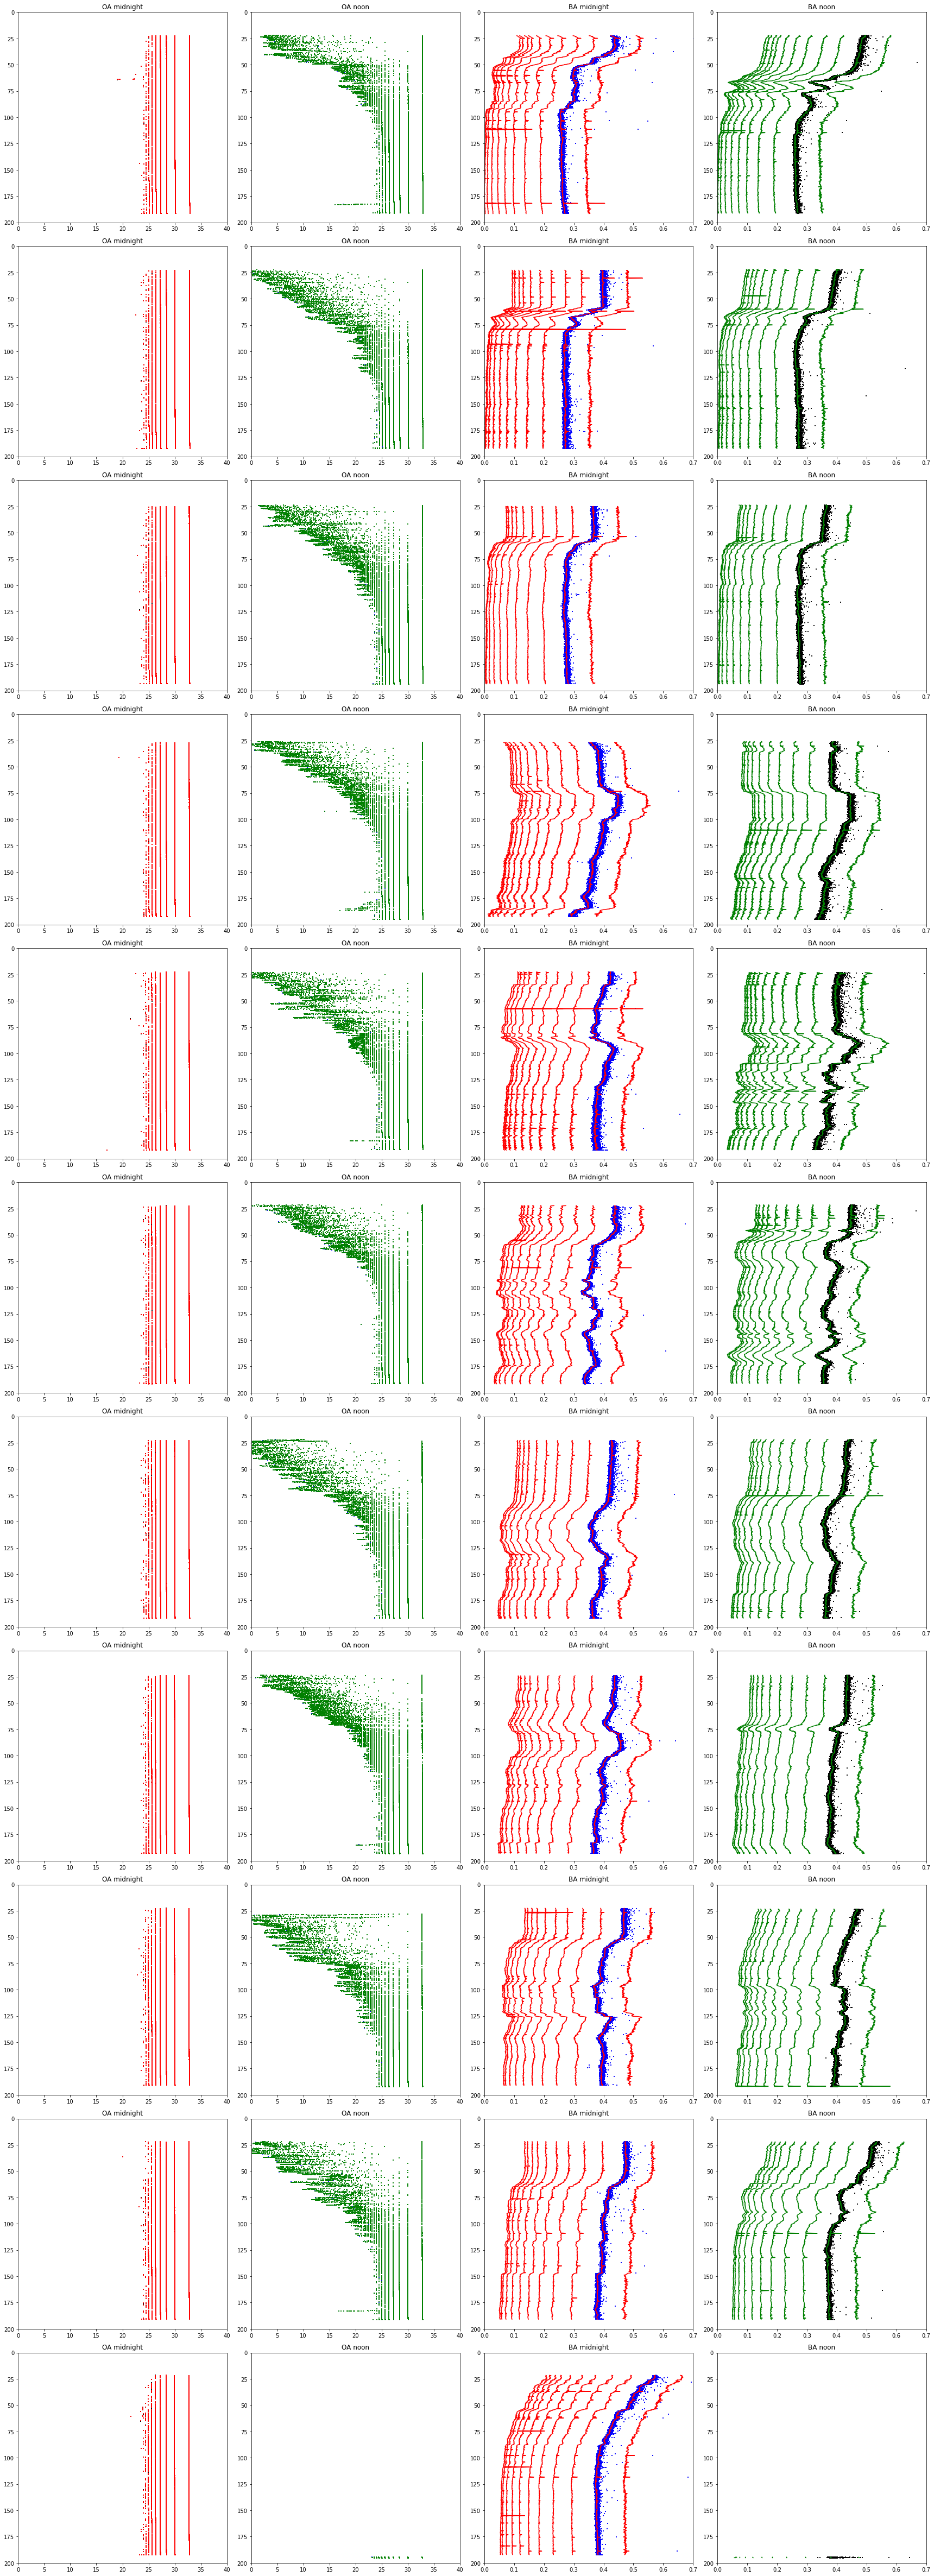

In [7]:
####################
#
# Spectrophotometer
#   OA = Optical Absorbance (data is noisier, particularly midnight)
#   BA = Beam Absorbance
#
# This code selects a subset of days and corresponds a number of plot rows, stacked vertically
#   going across you get oa midnight, noon and ba midnight, noon, so 4 across
#
####################

# single data read covers OA and BA, both ascents each day, 2019 JAN - SEP
spectrophotometer_source = '/data/rca/simpler/'
spectrophotometer_data = 'osb_sp_optaa_2019.nc'
ds_photometer = xr.open_dataset(spectrophotometer_source + spectrophotometer_data)

m_strs = ['01', '02', '03', '04', '05', '06', '07', '08', '09']           # relevant 2019 months
m_days = [31, 28, 31, 30, 31, 30, 31, 31, 30]                             # days per month in 2019

month_index = 0                                                           # manage time via months and days; 0 is January
month_str   = m_strs[month_index]  
year_str    = '2019'

n_meters          = 200
n_bins_per_meter  = 4
halfbin           = (1/2) * (1/n_bins_per_meter)
n_pressure_bins   = n_meters * n_bins_per_meter
n_wavelengths     = 86
wavelength        = [i for i in range(n_wavelengths)]
p_bounds          = np.linspace(0., n_meters, n_pressure_bins + 1)             # 801 bounds: 0., .25, ..., 200.                   
pressure          = np.linspace(halfbin, n_meters - halfbin, n_pressure_bins)  # 800 centers: 0.125, ..., 199.875                  
oa_upper_bound    = 40.
ba_upper_bound    = 0.7
wavelength_stride = 8

ndays = m_days[month_index]
ndayplots, dayplotdays = 11, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

l_da_oa_midn, l_da_oa_noon, l_da_ba_midn, l_da_ba_noon = [], [], [], []       # these lists accumulate DataArrays by day


fig_height, fig_width, fig_n_across, fig_n_down = 6, 6, 4, ndayplots
fig, axs = plt.subplots(fig_n_down, fig_n_across, figsize=(fig_width * fig_n_across, \
                                                           fig_height*fig_n_down), tight_layout=True)

# for day_index in range(m_days[month_index]):                                   # loop: days of a chosen month 
for day_index in range(ndays):
    
    day_str  = day_of_month_to_string(day_index + 1); date_str = year_str + '-' + month_str + '-' + day_str
    this_doy = doy(dt64(date_str))
    clear_output(wait = True); print("on day", day_str, 'i.e. doy', this_doy)
    midn_start = date_str + 'T07:00:00'
    midn_done  = date_str + 'T10:00:00'
    noon_start = date_str + 'T20:00:00'
    noon_done  = date_str + 'T23:00:00'

    # pull out OA and BA for both midnight and noon ascents; and swap in pressure for time
    ds_photometer_midn = ds_photometer.sel(time=slice(dt64(midn_start), \
                                                      dt64(midn_done))).swap_dims({'time':'int_ctd_pressure'})
    ds_photometer_noon = ds_photometer.sel(time=slice(dt64(noon_start), \
                                                      dt64(noon_done))).swap_dims({'time':'int_ctd_pressure'})
    
    da_oa_midn = ds_photometer_midn.optical_absorption.expand_dims({'doy':[this_doy]})
    da_oa_noon = ds_photometer_noon.optical_absorption.expand_dims({'doy':[this_doy]})
    da_ba_midn = ds_photometer_midn.beam_attenuation.expand_dims({'doy':[this_doy]})
    da_ba_noon = ds_photometer_noon.beam_attenuation.expand_dims({'doy':[this_doy]})
    
    del da_oa_midn['time']; del da_oa_noon['time']; del da_ba_midn['time']; del da_ba_noon['time']
    
    l_da_oa_midn.append(da_oa_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", \
                    p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_oa_noon.append(da_oa_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", \
                    p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_midn.append(da_ba_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", \
                    p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_noon.append(da_ba_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", \
                    p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    
    if day_index in dayplotdays:      # if this is a plotting day: Add to the chart repertoire
        
        dayplotindex = dayplotdays.index(day_index) 
        oa_plot_wavelength = 12
                
        axs[dayplotindex][0].scatter(l_da_oa_midn[-1][oa_plot_wavelength], pressure,  marker=',', s=1, color='k') 
        axs[dayplotindex][1].scatter(l_da_oa_noon[-1][oa_plot_wavelength], pressure,  marker=',', s=1, color='b') 
        axs[dayplotindex][0].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='OA midnight')
        axs[dayplotindex][1].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='OA noon')

        for chan_sel_index in range(2, 83, wavelength_stride):  
            axs[dayplotindex][2].plot(l_da_ba_midn[-1][chan_sel_index], pressure,  marker='', color='r') 
            axs[dayplotindex][3].plot(l_da_ba_noon[-1][chan_sel_index], pressure,  marker='', color='g')
        
        axs[dayplotindex][2].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA midnight')
        axs[dayplotindex][3].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA noon')

        # Superimpose raw to compare: OA shows quantization; BA shows noise, outliers and suspicious jumps
        axs[dayplotindex][0].scatter(ds_photometer_midn.optical_absorption.isel(wavelength = oa_plot_wavelength), \
                                     ds_photometer_midn.int_ctd_pressure, marker=',', s=1., color='r'); 
        axs[dayplotindex][1].scatter(ds_photometer_noon.optical_absorption.isel(wavelength = oa_plot_wavelength), \
                                     ds_photometer_noon.int_ctd_pressure, marker=',', s=1., color='g'); 
        axs[dayplotindex][2].scatter(ds_photometer_midn.beam_attenuation.isel(wavelength = 2 + wavelength_stride), \
                                     ds_photometer_midn.int_ctd_pressure, marker=',', s=1., color='b'); 
        axs[dayplotindex][3].scatter(ds_photometer_noon.beam_attenuation.isel(wavelength = 2 + wavelength_stride), \
                                     ds_photometer_noon.int_ctd_pressure, marker=',', s=1., color='k'); 

if False: 
    
    fig.savefig('/home/ubuntu/savefig.png')

    ds_oa_midn = xr.concat(l_da_oa_midn, dim="doy").to_dataset(name='optical_absorption')
    ds_oa_noon = xr.concat(l_da_oa_noon, dim="doy").to_dataset(name='optical_absorption')
    ds_ba_midn = xr.concat(l_da_ba_midn, dim="doy").to_dataset(name='beam_attenuation')
    ds_ba_noon = xr.concat(l_da_ba_noon, dim="doy").to_dataset(name='beam_attenuation')

    ds_oa_midn.to_netcdf("/data1/optaa/oa_midn_2019_01.nc")
    ds_oa_noon.to_netcdf("/data1/optaa/oa_noon_2019_01.nc")
    ds_ba_midn.to_netcdf("/data1/optaa/ba_midn_2019_01.nc")
    ds_ba_noon.to_netcdf("/data1/optaa/ba_noon_2019_01.nc")

In [ ]:
# Data preparation for Spectrophotometer: Binning the water column

from ipywidgets import *
from traitlets import dlink
warnings.filterwarnings('ignore')

# single data read covers OA and BA, both ascents each day, 2019 JAN - SEP
# to do: reorganize the dataset in a readable way. No idea if this is all of 2019 (Jan - Aug???)
ds_optaa = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_optaa_2019.nc')

m_strs = ['01', '02', '03', '04', '05', '06', '07', '08', '09']                # relevant 2019 months
m_days = [31, 28, 31, 30, 31, 30, 31, 31, 30]                                  # days per month in 2019
month_index = 0                                                                # manage time via months and days; 0 is January
month_str   = m_strs[month_index]  
year_str    = '2019'                                                           # prep for a date conversion

n_meters          = 200                                                        # depth we expect, roughly
n_bins_per_meter  = 4                                                          # prep for noise reduction filtering; .25cm vertical
halfbin           = (1/2) * (1/n_bins_per_meter)                               # 12.5 cm for "bin center depth" use
n_pressure_bins   = n_meters * n_bins_per_meter                                # 200 x 8 = 1600 intervals
n_wavelengths     = 86                                                         # spectrophotometer samples across 86 wavelengths
wavelength        = [i for i in range(n_wavelengths)]                          # list of integers 0...85
p_bounds          = np.linspace(0., n_meters, n_pressure_bins + 1)             # 801 bounds: 0., .25, ..., 200.                   
pressure          = np.linspace(halfbin, n_meters - halfbin, n_pressure_bins)  # 800 centers: 0.125, ..., 199.875                  
oa_upper_bound    = 40.                                                        # expected data ranges
ba_upper_bound    = 0.7
wavelength_stride = 8                                                          # skip across the wavelength bins

ndays = m_days[month_index]                                                    # number of days in this month

l_da_oa_midn, l_da_oa_noon, l_da_ba_midn, l_da_ba_noon = [], [], [], []        # these DataArray lists accumulate by day across the month:
                                                                               #   l = list
                                                                               #   da = data array
                                                                               #   oa/ba = optical absorption / beam attenuation
                                                                               #   midn / noon = local time of profile

for day_index in range(ndays):
    
    day_str  = day_of_month_to_string(day_index + 1); date_str = year_str + '-' + month_str + '-' + day_str
    this_doy = doy(dt64(date_str))
    
    # progress message
    clear_output(wait = True); print("on day", day_str, 'i.e. doy', this_doy, 'of', ndays)

    midn_start = date_str + 'T07:00:00'
    midn_done  = date_str + 'T10:00:00'
    noon_start = date_str + 'T20:00:00'
    noon_done  = date_str + 'T23:00:00'

    # pull out OA and BA for both midnight and noon ascents; and swap in pressure for time
    ds_midn = ds_optaa.sel(time=slice(dt64(midn_start), dt64(midn_done))).swap_dims({'time':'int_ctd_pressure'})
    ds_noon = ds_optaa.sel(time=slice(dt64(noon_start), dt64(noon_done))).swap_dims({'time':'int_ctd_pressure'})
    
    if day_index == 0:
        reference_ds_midn = ds_midn.copy()
        reference_ds_noon = ds_noon.copy()
    
    da_oa_midn = ds_midn.optical_absorption.expand_dims({'doy':[this_doy]})
    da_oa_noon = ds_noon.optical_absorption.expand_dims({'doy':[this_doy]})
    da_ba_midn = ds_midn.beam_attenuation.expand_dims({'doy':[this_doy]})
    da_ba_noon = ds_noon.beam_attenuation.expand_dims({'doy':[this_doy]})
    
    del da_oa_midn['time']; del da_oa_noon['time']; del da_ba_midn['time']; del da_ba_noon['time']
    
    l_da_oa_midn.append(da_oa_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_oa_noon.append(da_oa_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_midn.append(da_ba_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_noon.append(da_ba_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))



# We have two charts per day (midnight and noon) and two observation types (OA and BA). This is 2 x 2 charts. 
#   The display is 2 such blocks, left and right, for 4 x 2 charts. When the checkbox is True we use the passed
#   values for the right chart and the stored values for the left. When the checkbox is False we use the passed
#   values for the left chart and the stored values for the right. In either case the updated states are stored
#   in global state variables. If the day is 0 there is no plot. A four-chart state is { day_ba, day_oa, channel_oa }.

g_day_ba, g_day_oa, g_channel_oa = [8, 0], [8, 0], [50, 0] 

def spectrophotometer_display(sel_day_ba, sel_day_oa, sel_channel_oa, right):
    
    global g_day_ba, g_day_oa, g_channel_oa
    
    day_ba = g_day_ba[:]
    day_oa = g_day_oa[:]
    channel_oa = g_channel_oa[:]
    
    fig,axs = plt.subplots(2,4,figsize=(18,9), tight_layout=True)
    
    if right:
        day_ba[0], day_oa[0], channel_oa[0] = g_day_ba[0], g_day_oa[0], g_channel_oa[0]
        day_ba[1], day_oa[1], channel_oa[1] = sel_day_ba, sel_day_oa, sel_channel_oa
    else:
        day_ba[0], day_oa[0], channel_oa[1] = sel_day_ba, sel_day_oa, sel_channel_oa
        day_ba[1], day_oa[1], channel_oa[1] = g_day_ba[1], g_day_oa[1], g_channel_oa[1]

    g_day_ba, g_day_oa, g_channel_oa = day_ba[:], day_oa[:], channel_oa[:]

    # downshift to array indexing
    day_ba_index = [day_ba[0]-1, day_ba[1]-1]
    day_oa_index = [day_oa[0]-1, day_oa[1]-1]

    for i in range(2):
        
        hbias = 2*i
        
        ########
        # beam attenuation
        ########
        if day_ba[i] > 0:
            
            for chan_sel_index in range(2, 83, wavelength_stride):           
                axs[0][0 + hbias].plot(l_da_ba_midn[day_ba_index[i]][chan_sel_index], pressure,  marker='', color='r') 
                axs[0][1 + hbias].plot(l_da_ba_noon[day_ba_index[i]][chan_sel_index], pressure,  marker='', color='g')

            axs[0][0 + hbias].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='midnight BA')
            axs[0][1 + hbias].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='noon BA')

            axs[0][0 + hbias].text(.1, 12, 'near surface, doy ' + str(day_ba[i]))
            axs[0][1 + hbias].text(.1, 12, 'near surface, doy ' + str(day_ba[i]))

            if day_ba[i] == 1:
                axs[0][0 + hbias].scatter(reference_ds_midn.beam_attenuation.isel(wavelength = 2 + wavelength_stride), 
                                  reference_ds_midn.int_ctd_pressure, 
                                  marker=',', s=1., color='b'); 
                axs[0][1 + hbias].scatter(reference_ds_noon.beam_attenuation.isel(wavelength = 2 + wavelength_stride), 
                                  reference_ds_noon.int_ctd_pressure, 
                                  marker=',', s=1., color='k');  
        ########
        # optical absorption
        ########
        if day_oa[i] > 0:

            axs[1][0 + hbias].scatter(l_da_oa_midn[day_oa_index[i]][channel_oa[i]], pressure,  marker=',', s=1, color='k') 
            axs[1][1 + hbias].scatter(l_da_oa_noon[day_oa_index[i]][channel_oa[i]], pressure,  marker=',', s=1, color='b') 

            axs[1][0 + hbias].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='midnight OA')
            axs[1][1 + hbias].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='noon OA')

            axs[1][0 + hbias].text(5, 12, 'near surface, doy ' + str(day_oa[i]))
            axs[1][1 + hbias].text(5, 12, 'near surface, doy ' + str(day_oa[i])) 

            if day_oa == 1:
                axs[1][0 + hbias].scatter(reference_ds_midn.optical_absorption.isel(wavelength=channel_oa), 
                                  reference_ds_midn.int_ctd_pressure, 
                                  marker=',', s=1., color='r');
                axs[1][1 + hbias].scatter(reference_ds_noon.optical_absorption.isel(wavelength=channel_oa), 
                                  reference_ds_noon.int_ctd_pressure, 
                                  marker=',', s=1., color='g');

interact(spectrophotometer_display, \
         sel_day_ba=widgets.IntSlider(min=1, max=31, step=1, value=9,  continuous_update=False, description='BAtten'),
         sel_day_oa=widgets.IntSlider(min=1, max=31, step=1, value=9,  continuous_update=False, description='OAbs'),
         sel_channel_oa=widgets.IntSlider(min=1, max=82, step=1, value=49,  continuous_update=False, description='OA Chan'),
         right = widgets.ToggleButton(value=False, description='use right charts', disabled=False,
             button_style='', tooltip='Description', icon='check')
    )